In [83]:
import json
import random
from tqdm import tqdm
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [2]:
with open('data/processed_corpus.json') as f:
    corpus = json.load(f)

In [3]:
len(corpus)

100000

In [4]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

In [5]:
sample_text = corpus[1]

In [6]:
' '.join(sample_text)

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

# Реализуйте разделение предложения на примеры методом CBOW

In [7]:
i=5
window = 2
print(sample_text[i-window:i])
print(sample_text[i])
print(sample_text[i+1: i+window+1])

['лицевой', 'счёт']
либо
['зачесть', 'счёт']


In [8]:
def cbow_split(tokens, window, pad_token='PAD'):
    
    splits = []
    for i in range(len(tokens)):
        if i - window < 0:
            pads_num = window - i
            pads = [pad_token] * pads_num
            words = tokens[:i]
            ans = []
            ans.extend(pads)
            ans.extend(words)
            splits.append([ans, tokens[i], tokens[i+1: i+window+1]])
        elif i > len(tokens) - window - 1:
            pads_num = window - (len(tokens) - i) + 1
            pads = [pad_token] * pads_num
            words = tokens[i+1:]
            ans = []
            ans.extend(words)
            ans.extend(pads)
            splits.append([tokens[i-window:i], tokens[i], ans])
        else:
            splits.append([tokens[i-window:i], tokens[i], tokens[i+1: i+window+1]])
            
        
    return splits

In [9]:
splits = cbow_split(sample_text, window=2)

In [10]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: вернуть
Правый контекст: ['денежный', 'средство']

Левый контекст: ['PAD', 'вернуть']
Центральное слово: денежный
Правый контекст: ['средство', 'лицевой']

Левый контекст: ['вернуть', 'денежный']
Центральное слово: средство
Правый контекст: ['лицевой', 'счёт']

Левый контекст: ['денежный', 'средство']
Центральное слово: лицевой
Правый контекст: ['счёт', 'либо']

Левый контекст: ['средство', 'лицевой']
Центральное слово: счёт
Правый контекст: ['либо', 'зачесть']

Левый контекст: ['лицевой', 'счёт']
Центральное слово: либо
Правый контекст: ['зачесть', 'счёт']

Левый контекст: ['счёт', 'либо']
Центральное слово: зачесть
Правый контекст: ['счёт', 'погашение']

Левый контекст: ['либо', 'зачесть']
Центральное слово: счёт
Правый контекст: ['погашение', 'кредит']

Левый контекст: ['зачесть', 'счёт']
Центральное слово: погашение
Правый контекст: ['кредит', 'PAD']

Левый контекст: ['счёт', 'погашение']
Центральное слово: кредит
Правый контекст: [

In [11]:
splits

[[['PAD', 'PAD'], 'вернуть', ['денежный', 'средство']],
 [['PAD', 'вернуть'], 'денежный', ['средство', 'лицевой']],
 [['вернуть', 'денежный'], 'средство', ['лицевой', 'счёт']],
 [['денежный', 'средство'], 'лицевой', ['счёт', 'либо']],
 [['средство', 'лицевой'], 'счёт', ['либо', 'зачесть']],
 [['лицевой', 'счёт'], 'либо', ['зачесть', 'счёт']],
 [['счёт', 'либо'], 'зачесть', ['счёт', 'погашение']],
 [['либо', 'зачесть'], 'счёт', ['погашение', 'кредит']],
 [['зачесть', 'счёт'], 'погашение', ['кредит', 'PAD']],
 [['счёт', 'погашение'], 'кредит', ['PAD', 'PAD']]]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [12]:
cbow_split(sample_text, window=3)

[[['PAD', 'PAD', 'PAD'], 'вернуть', ['денежный', 'средство', 'лицевой']],
 [['PAD', 'PAD', 'вернуть'], 'денежный', ['средство', 'лицевой', 'счёт']],
 [['PAD', 'вернуть', 'денежный'], 'средство', ['лицевой', 'счёт', 'либо']],
 [['вернуть', 'денежный', 'средство'], 'лицевой', ['счёт', 'либо', 'зачесть']],
 [['денежный', 'средство', 'лицевой'], 'счёт', ['либо', 'зачесть', 'счёт']],
 [['средство', 'лицевой', 'счёт'], 'либо', ['зачесть', 'счёт', 'погашение']],
 [['лицевой', 'счёт', 'либо'], 'зачесть', ['счёт', 'погашение', 'кредит']],
 [['счёт', 'либо', 'зачесть'], 'счёт', ['погашение', 'кредит', 'PAD']],
 [['либо', 'зачесть', 'счёт'], 'погашение', ['кредит', 'PAD', 'PAD']],
 [['зачесть', 'счёт', 'погашение'], 'кредит', ['PAD', 'PAD', 'PAD']]]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [13]:
' '.join(sample_text)

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

# Реализуйте разделение предложения на примеры методом Skipgram

In [14]:
def skipgram_split(tokens, window):
    
    splits = []
    
    for i, center in enumerate(tokens):
        left = max(i-window, 0)
        right = min(i+window+1, len(tokens))
        full_context = tokens[left:i] + tokens[i+1:right]
        for context in full_context:
            splits.append((context, center))
    
    return splits

In [15]:
splits = skipgram_split(sample_text, window=2)

In [16]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: денежный
Центральное слово: вернуть

Контекст: средство
Центральное слово: вернуть

Контекст: вернуть
Центральное слово: денежный

Контекст: средство
Центральное слово: денежный

Контекст: лицевой
Центральное слово: денежный

Контекст: вернуть
Центральное слово: средство

Контекст: денежный
Центральное слово: средство

Контекст: лицевой
Центральное слово: средство

Контекст: счёт
Центральное слово: средство

Контекст: денежный
Центральное слово: лицевой

Контекст: средство
Центральное слово: лицевой

Контекст: счёт
Центральное слово: лицевой

Контекст: либо
Центральное слово: лицевой

Контекст: средство
Центральное слово: счёт

Контекст: лицевой
Центральное слово: счёт

Контекст: либо
Центральное слово: счёт

Контекст: зачесть
Центральное слово: счёт

Контекст: лицевой
Центральное слово: либо

Контекст: счёт
Центральное слово: либо

Контекст: зачесть
Центральное слово: либо

Контекст: счёт
Центральное слово: либо

Контекст: счёт
Центральное слово: зачесть

Контекст: либо
Цент

In [17]:
skipgram_split(sample_text, window=2)

[('денежный', 'вернуть'),
 ('средство', 'вернуть'),
 ('вернуть', 'денежный'),
 ('средство', 'денежный'),
 ('лицевой', 'денежный'),
 ('вернуть', 'средство'),
 ('денежный', 'средство'),
 ('лицевой', 'средство'),
 ('счёт', 'средство'),
 ('денежный', 'лицевой'),
 ('средство', 'лицевой'),
 ('счёт', 'лицевой'),
 ('либо', 'лицевой'),
 ('средство', 'счёт'),
 ('лицевой', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('лицевой', 'либо'),
 ('счёт', 'либо'),
 ('зачесть', 'либо'),
 ('счёт', 'либо'),
 ('счёт', 'зачесть'),
 ('либо', 'зачесть'),
 ('счёт', 'зачесть'),
 ('погашение', 'зачесть'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('погашение', 'счёт'),
 ('кредит', 'счёт'),
 ('зачесть', 'погашение'),
 ('счёт', 'погашение'),
 ('кредит', 'погашение'),
 ('счёт', 'кредит'),
 ('погашение', 'кредит')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [18]:
skipgram_split(sample_text, window=3)

[('денежный', 'вернуть'),
 ('средство', 'вернуть'),
 ('лицевой', 'вернуть'),
 ('вернуть', 'денежный'),
 ('средство', 'денежный'),
 ('лицевой', 'денежный'),
 ('счёт', 'денежный'),
 ('вернуть', 'средство'),
 ('денежный', 'средство'),
 ('лицевой', 'средство'),
 ('счёт', 'средство'),
 ('либо', 'средство'),
 ('вернуть', 'лицевой'),
 ('денежный', 'лицевой'),
 ('средство', 'лицевой'),
 ('счёт', 'лицевой'),
 ('либо', 'лицевой'),
 ('зачесть', 'лицевой'),
 ('денежный', 'счёт'),
 ('средство', 'счёт'),
 ('лицевой', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('счёт', 'счёт'),
 ('средство', 'либо'),
 ('лицевой', 'либо'),
 ('счёт', 'либо'),
 ('зачесть', 'либо'),
 ('счёт', 'либо'),
 ('погашение', 'либо'),
 ('лицевой', 'зачесть'),
 ('счёт', 'зачесть'),
 ('либо', 'зачесть'),
 ('счёт', 'зачесть'),
 ('погашение', 'зачесть'),
 ('кредит', 'зачесть'),
 ('счёт', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('погашение', 'счёт'),
 ('кредит', 'счёт'),
 ('либо', 'погашение'),
 ('зачесть', 'погашени

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [19]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [20]:
len(word2index)

13076

In [21]:
word2index['UNK']

1

In [22]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [23]:
from torch.utils.data import Dataset, DataLoader

In [24]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [25]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.17501312, 0.62490364, 0.37277364, 0.45565365],
       [0.52952543, 0.63832936, 0.19768275, 0.87783778],
       [0.90925404, 0.32019934, 0.28953826, 0.40584944],
       [0.19614776, 0.76311604, 0.55353046, 0.16579185],
       [0.52157438, 0.89326632, 0.93088963, 0.9945882 ],
       [0.68108049, 0.42362544, 0.61642547, 0.19804344],
       [0.02312582, 0.76211762, 0.51195003, 0.0164782 ],
       [0.99448014, 0.96961983, 0.95756237, 0.97200808],
       [0.63100821, 0.19161877, 0.51608506, 0.93151959],
       [0.81141022, 0.62618557, 0.15608043, 0.1036762 ]])

In [26]:
some_data_y

array([1, 1, 2, ..., 0, 2, 0])

In [27]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [28]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [29]:
some_dataset[5], some_dataset[467]

((array([0.68108049, 0.42362544, 0.61642547, 0.19804344]), 1),
 (array([0.59853473, 0.38896054, 0.28984523, 0.2430273 ]), 2))

In [30]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [31]:
for x, y in some_loader:
    break
    
len(x), x

(16,
 tensor([[0.2175, 0.3610, 0.6289, 0.1156],
         [0.5920, 0.7089, 0.5836, 0.0704],
         [0.1081, 0.3693, 0.0821, 0.7108],
         [0.4750, 0.5068, 0.1673, 0.2946],
         [0.2678, 0.0518, 0.5305, 0.8977],
         [0.8176, 0.5527, 0.0317, 0.8921],
         [0.3689, 0.5352, 0.7916, 0.5152],
         [0.4499, 0.9123, 0.1645, 0.6574],
         [0.5424, 0.8872, 0.1789, 0.8417],
         [0.3312, 0.6066, 0.7160, 0.1681],
         [0.8997, 0.6396, 0.1011, 0.2446],
         [0.4145, 0.4333, 0.3461, 0.3335],
         [0.8020, 0.2231, 0.9500, 0.2582],
         [0.8571, 0.4161, 0.8904, 0.4358],
         [0.9498, 0.3607, 0.9323, 0.6079],
         [0.9913, 0.1473, 0.8562, 0.1695]], dtype=torch.float64))

In [32]:
for x, y in some_loader:
    pass

len(x)

15

In [33]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [34]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [35]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [36]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [37]:
for x, y in toy_loader:
    break

In [38]:
x.shape

torch.Size([128, 32])

In [39]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[ 1.7501e-01,  6.2490e-01,  3.7277e-01,  ..., -2.8209e+00,
         -5.9207e+00, -4.7161e+00],
        [ 5.2953e-01,  6.3833e-01,  1.9768e-01,  ..., -2.6934e+00,
         -9.7266e+00, -7.8176e-01],
        [ 9.0925e-01,  3.2020e-01,  2.8954e-01,  ..., -6.8329e+00,
         -7.4368e+00, -5.4106e+00],
        ...,
        [ 7.4002e-01,  2.1737e-02,  7.8049e-01,  ..., -2.2973e+01,
         -1.4870e+00, -1.6697e-01],
        [ 1.9845e-02,  4.6372e-01,  6.1528e-01,  ..., -4.6108e+00,
         -2.9140e+00, -1.0677e+01],
        [ 4.9421e-02,  6.2111e-01,  6.2600e-01,  ..., -2.8575e+00,
         -2.8105e+00, -6.4095e+00]], dtype=torch.float64)

In [40]:
y

tensor([1, 1, 2, 0, 1, 1, 0, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 0, 0, 1, 0, 2, 2, 0,
        1, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0, 0, 2, 2, 1, 1, 0, 2, 1, 2, 1, 0, 1,
        2, 0, 0, 1, 2, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 2, 1, 2, 2, 2, 0, 2, 1, 2,
        2, 1, 1, 0, 1, 0, 2, 2, 0, 2, 0, 1, 0, 1, 2, 2, 0, 1, 0, 1, 1, 0, 1, 2,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 0, 2, 0, 1, 1, 1, 1, 0, 2,
        0, 2, 2, 2, 1, 0, 1, 2])

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [41]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [42]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)
    
loss.item()

1.114823579788208

# Боевые датасеты

In [43]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [44]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
        
        # CODE
        # вставить здесь функцию, которые вы писали раньше
        splits = []
    
        for i, center in enumerate(tokenized_text):
            left = max(i-window, 0)
            right = min(i+window+1, len(tokenized_text))
            full_context = tokenized_text[left:i] + tokenized_text[i+1:right]
            for context in full_context:
                splits.append((context, center))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        # CODE
        context, central_word = self.data[idx]
        
        return context, central_word

In [45]:
# можете положить SkipgramDataset в отдельный файлик, например word2vec_utils и относительным импортом достать его 
#from .word2vec_utils import SkipgramDataset

In [46]:
dataset = SkipgramDataset(corpus, word2index)

100%|██████████| 100000/100000 [00:02<00:00, 47937.42it/s]


In [47]:
BATCH_SIZE = 512

In [48]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [49]:
i =0
for x, y in dataset_loader:
    i+=1
    if i > 10:
        break

In [50]:
x[:5]

tensor([  55, 3098,  724,  233,  269])

In [51]:
y[:5]

tensor([ 343,  108,  224, 1176,  194])

In [52]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [53]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        # первый параметр  - размер всего словаря, второй параметр размер получаемого эмбеддинга и паддинг еще
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [54]:
# CODE
class SkipGram(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()
        
        # первый параметр  - размер всего словаря, второй параметр размер получаемого эмбеддинга
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x)
        x = self.out_embedding(x)
        
        return x

In [55]:
#from word2vec_utils import SkipGram

In [56]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [57]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [58]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13076])

In [59]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [60]:
epochs = 3

losses = []


for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:

            # CODE
#             optimizer.zero_grad()  #обнуляем градиенты
            pred = model(x) #прогоняем данные через модель
            loss = criterion(pred, y) #считаем значение функции потерь  
            loss.backward() #считаем градиенты 
            optimizer.step() #обновляем веса 
            # CODE
            
            losses.append(loss.item()) #сохраняем значение функции потерь
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|██████████| 2983124/2983124 [05:53<00:00, 8440.88it/s, loss=7.1]  


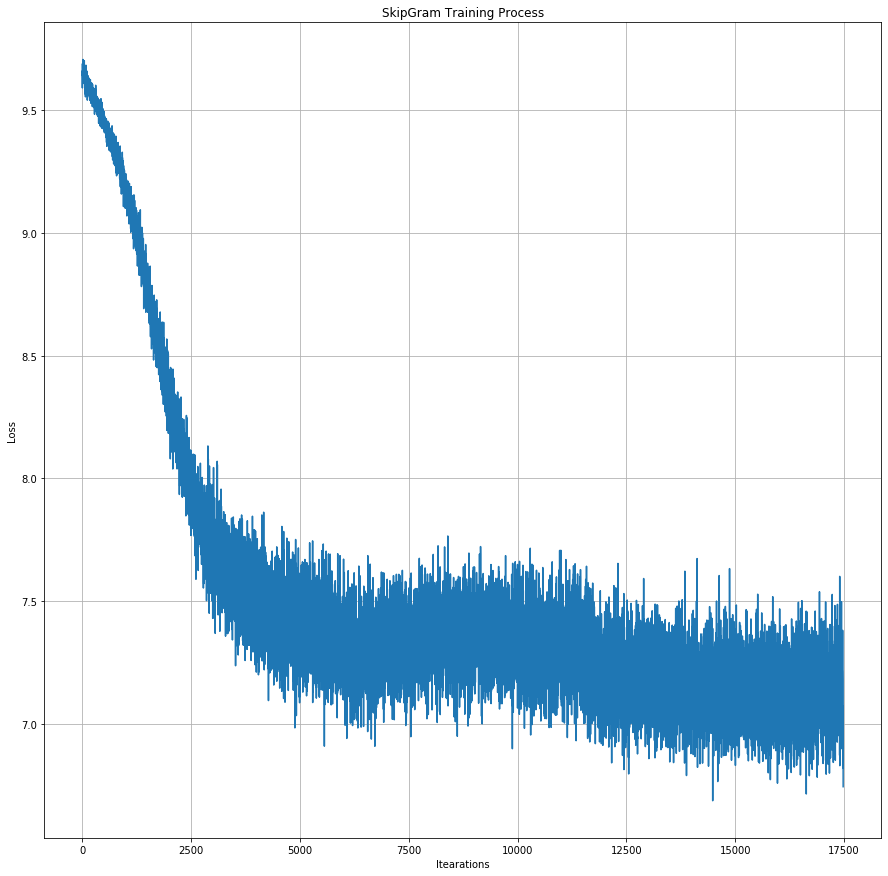

In [61]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [62]:
np.mean(losses[-1000:])

7.126326775550842

In [63]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [64]:
embedding_matrix = model.in_embedding.weight.detach()

In [65]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [66]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.656667947769165

In [67]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.6152100563049316

In [68]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.7484689950942993

In [69]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.6726618409156799

In [70]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "отвечь" равна 0.334'

In [71]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [72]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [73]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.016s...
[t-SNE] Computed neighbors for 13076 samples in 6.685s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076
[t-SNE] Computed conditional probabilities for sam

In [74]:
top_words = [a for a,_ in top_sorted_freq]

In [75]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

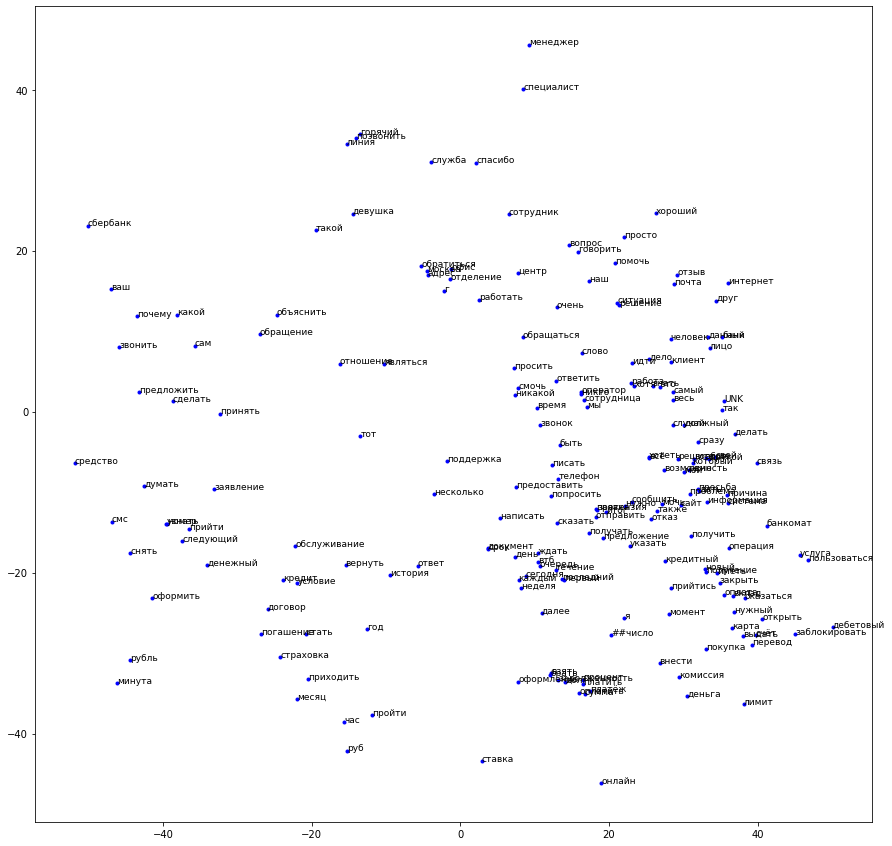

In [76]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

# Оценка
1. Вы добрались сюда и все работает, значит уже получили 7 баллов.
2. 8 баллов - Взяли корпус для оценка качества эмбеддингов [здесь](https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv). Описание к нему [здесь](https://arxiv.org/pdf/1801.06407.pdf). Его английская версия для понимания, того что же это такое [тут](https://fh295.github.io/simlex.html). Если в кратце - он похож а гугл аналогии, просто иначе составлен. Определили качество своих эмбеддингов. Как качество измерить? Можете все значения отнормировать (привести к 1) и затем считать MSE между тем что у вас и что в оригинале.
3. 9 баллов - Поставили эксперименты, поменяли любые параметры, хоть корпус увеличили или как то почистили. Показали метрики до и после. После должно быть лучше, иначе это все еще 8 баллов.
4. 10 баллов - удивили своим подходом (или просто удивили) пока делили на 9 баллов

# Оценка качества эмбеддингов

In [80]:
df_ref = pd.read_csv('./data/ru_simlex965_tagged.tsv', delimiter='\t')
df_ref.head(3)

,# Word1,Word2,Average Score
0,авария_NOUN,бедствие_NOUN,6.15
1,август_NOUN,месяц_NOUN,2.85
2,авиация_NOUN,полет_NOUN,6.77


In [82]:
df_ref['# Word1'] = df_ref['# Word1'].apply(lambda x: x.split('_')[0])
df_ref['Word2'] = df_ref['Word2'].apply(lambda x: x.split('_')[0])
df_ref.head(3)

,# Word1,Word2,Average Score
0,авария,бедствие,6.15
1,август,месяц,2.85
2,авиация,полет,6.77


Нормируем скоры

In [85]:
scaler = MinMaxScaler()
df_ref['Normed Score'] = scaler.fit_transform(df_ref[['Average Score']])
df_ref.head(3)

,# Word1,Word2,Average Score,Normed Score
0,авария,бедствие,6.15,0.615
1,август,месяц,2.85,0.285
2,авиация,полет,6.77,0.677


In [88]:
voc = word2index.keys()

scores = []
# итерируемся по строчкам
for idx, row in df_ref.iterrows():
    if row['# Word1'] in voc and row['Word2'] in voc:
        sim = cos_sim(embedding_matrix, word2index, row['# Word1'], row['Word2'])
        scores.append(sim)
    # нет скора для слова - не рассматриваем его
    else:
        df_ref.drop([idx], inplace=True)

In [96]:
df_ref['Embedding Scores'] = scores
df_ref['Normed Embedding Scores'] = [float(i)/max(scores) for i in scores]
df_ref.head(3)

,# Word1,Word2,Average Score,Normed Score,Embedding Scores,Normed Embedding Scores
1,август,месяц,2.85,0.285,0.804378,0.943789
3,автомобиль,гудок,1.85,0.185,0.503030,0.590213
5,автомобиль,такси,4.15,0.415,0.423008,0.496322


In [98]:
mse_1 = mean_squared_error(df_ref['Normed Score'], df_ref['Normed Embedding Scores'])
mse_1

0.16828521927880014

# Эксперименты


Прежде чем ставить эксперименты, надо понять, что можно поделать, чтобы улучшить нашу метрику: 

* подумать насчет препроцессинга данных (попробую увеличить размер словаря, потому что в двух датасетах немного разная лексика ((это **очень важный фактор**) - в SimLex достаточно "нейтральный" стиль, а в корпусе нашем - более банковская лексика, это нехорошо),  то есть понизить порог частотности слов, оставлю лемматизацию, хотя у меня чисто на практике чаще "выигрывают" токены - здесь из соображений вычислительных ресурсов это может быть крайняя мера)
* подумать насчет параметров обучения модели, возможно, надо будет поизменять learning_rate, число эпох и т.д.

Поэтому я: 

* В препроцессинге данных я оставила ту же лемматизацию, но понизила порог (теперь минимальное число вхождения в текст - 10, а не 15, как было ранее), но сохранила объем корпуса - 10.000.

*  Взяла окно в 2 раза больше (стало 4,  было - 2), чем было, в SkipgramDataset (кажется, так улучшится "понимание" контекста моделью)

* Увеличила размер эмбеддинга до 300 (как самый классический вариант размера)

* Уменьшила размер шага в 2 раза (был lr = 0.0001, стало lr=0.00005)

In [116]:
with open('./data/processed_corpus2.json') as f:
    corpus2 = json.load(f)
    
word2index2 = {}

for text in corpus2:
    for token in text:
        if token not in word2index2:
            word2index2[token] = len(word2index2)

In [117]:
dataset2 = SkipgramDataset(corpus2, word2index2, window=4)
BATCH_SIZE = 512
dataset2_loader = DataLoader(dataset2, shuffle=True, batch_size=BATCH_SIZE)

model2 = SkipGram(vocab_size=len(word2index), embedding_dim=300)

optimizer = torch.optim.Adam(params=model2.parameters(), lr=0.00005)
criterion = torch.nn.CrossEntropyLoss()

100%|██████████| 100000/100000 [00:04<00:00, 20346.02it/s]


In [118]:
epochs = 3

losses2 = []


for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset2_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset2_loader:

            # CODE
#             optimizer.zero_grad()  #обнуляем градиенты
            pred = model2(x) #прогоняем данные через модель
            loss = criterion(pred, y) #считаем значение функции потерь  
            loss.backward() #считаем градиенты 
            optimizer.step() #обновляем веса 
            # CODE
            
            losses2.append(loss.item()) #сохраняем значение функции потерь
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|██████████| 2986628/2986628 [14:55<00:00, 3334.24it/s, loss=7.1]


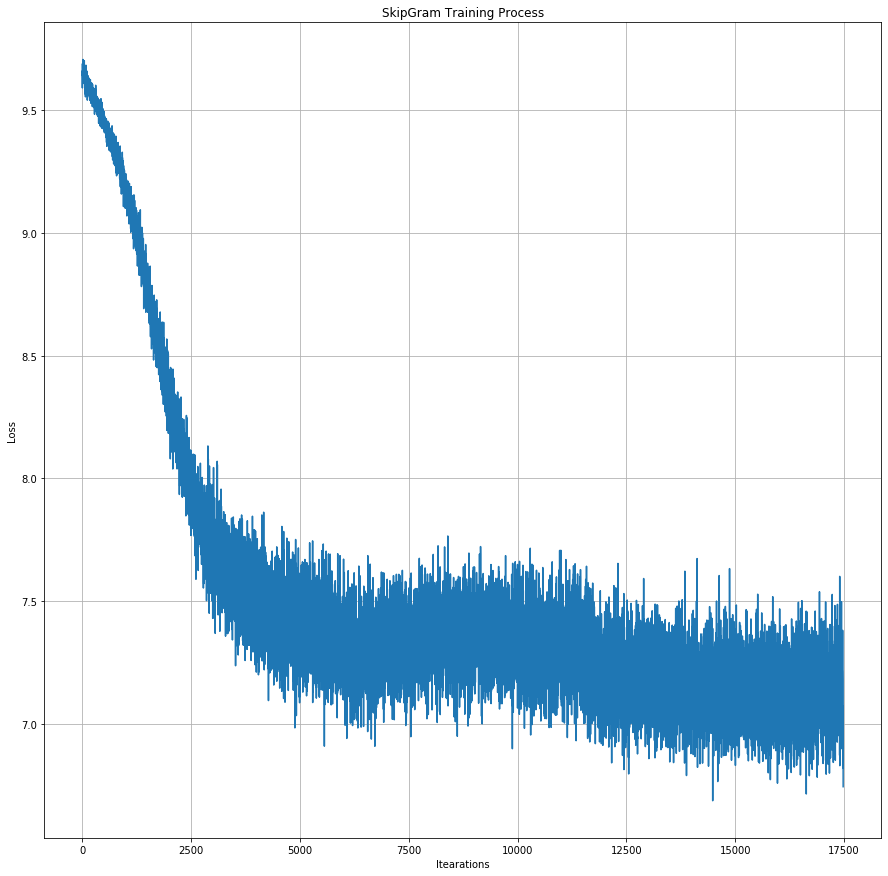

In [119]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [120]:
np.mean(losses[-1000:])

7.126326775550842

In [121]:
assert np.mean(losses[-1000:]) < 7.5

In [122]:
embedding_matrix2 = model2.in_embedding.weight.detach()

In [123]:
df_ref2 = df_ref.copy()

In [124]:
voc2 = word2index2.keys()

scores2 = []
# итерируемся по строчкам
for idx, row in df_ref.iterrows():
    if row['# Word1'] in voc2 and row['Word2'] in voc2:
        sim = cos_sim(embedding_matrix2, word2index2, row['# Word1'], row['Word2'])
        scores2.append(sim)
    # нет скора для слова - не рассматриваем его
    else:
        df_ref.drop([idx], inplace=True)

In [125]:
df_ref2['Embedding Scores-2'] = scores2
df_ref2['Normed Embedding Scores-2'] = [float(i)/max(scores) for i in scores2]
df_ref2.head(3)

,# Word1,Word2,Average Score,Normed Score,Embedding Scores,Normed Embedding Scores,Embedding Scores-2,Normed Embedding Scores-2
1,август,месяц,2.85,0.285,0.804378,0.943789,0.275649,0.323423
3,автомобиль,гудок,1.85,0.185,0.503030,0.590213,0.219713,0.257792
5,автомобиль,такси,4.15,0.415,0.423008,0.496322,0.145788,0.171055


In [126]:
mse_2 = mean_squared_error(df_ref2['Normed Score'], df_ref2['Normed Embedding Scores-2'])
mse_2

0.12533775527941915

Общий итог:

Действительно стали лучше показатели, это отличная новость, но сказать точно, что именно улучшило скор, нет возможности, поэтому в идеале мои идеи хорошо бы поперебирать, а не "в лоб" одни параметры ставить, я бы точно еще бы пересмотрела бы значение learning_rate, точно бы посмотрела на trade-off между размером эбеддинга и качеством в зависимости от этого, точно бы посмотрела точно так же на размеры окон (до 10), понятно, что можно и другие параметры поперебирать, но меня в целом интуитивно перечисленные больше всего интересуют. При бОльшем количестве времени, а, главное, вычислительных мощностей я точно бы плотнее занялась бы этим вопросом.

Также мне очень интересен такой подход: можно брать в наш корпус только те слова, которые есть в референсном корпусе. Это поможет "нейтрализовать" банковскую лексику, но при этом и сама модель вряд ли лучше усвоит зависимость встречаемости слов, но попробовать можно.

Считаю все мои подходы хорошими с продуманной и обоснованной логикой. Все, что было задумано, реализовано и привело к улучшению значения метрики.

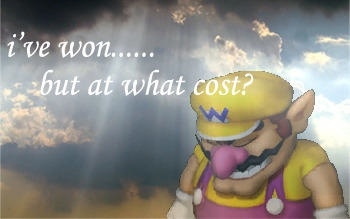

In [130]:
from IPython.display import Image
Image(filename = "picture.jpg", width=300, height=300)